In [1]:
! pip install dlib
! pip install imageio
! pip install imageio-ffmpeg

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import dlib 
from scipy.spatial import Delaunay
import os
import io
import imageio
import imageio_ffmpeg


# Part1

# 1. Correspondences


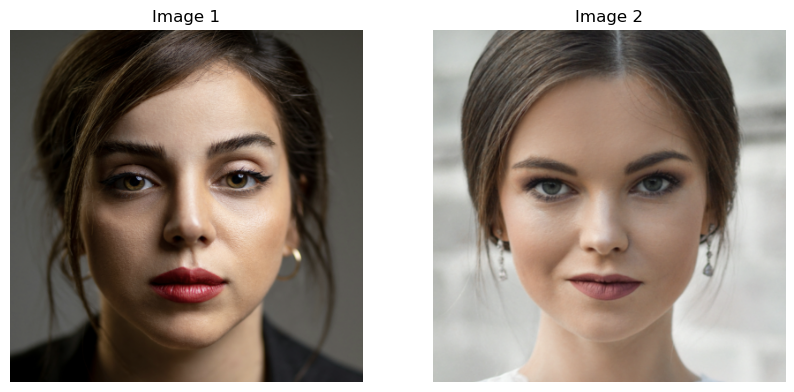

In [2]:
# Images from 
# https://unsplash.com/photos/woman-with-red-lipstick-and-black-mascara-vsWy6nchcOs
# https://unsplash.com/photos/shallow-focus-photo-of-woman-standing-near-wall-eDVQwVMLMgU
# Images are resized to the same dimensions for easier comparison
img1 = cv2.imread('img1.jpg')
img2 = cv2.imread('img2.jpg')

# When resizing an image to smaller dimensions, cv2.INTER_AREA takes the average of pixel areas to compute the new pixel values.
img1_resized = cv2.resize(img1, (400, 400), interpolation=cv2.INTER_AREA) 
img2_resized = cv2.resize(img2, (400, 400), interpolation=cv2.INTER_AREA)

img1_rgb = cv2.cvtColor(img1_resized, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2_resized, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img1_rgb)
plt.title("Image 1")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img2_rgb)
plt.title("Image 2")
plt.axis('off')

plt.show()


In [3]:

def get_landmarks(image):
    
    face_detector = dlib.get_frontal_face_detector()
    landmark_predictor = dlib.shape_predictor("./shape_predictor_68_face_landmarks.dat")

    faces = face_detector(image)
    landmarks = landmark_predictor(image, faces[0])
    points = np.array([[landmarks.part(i).x, landmarks.part(i).y] for i in range(68)])
    
    h, w = image.shape[:2]
    # Add corner points of the image 
    corners = np.array([[0, 0], [w - 1, 0], [0, h - 1], [w - 1, h - 1]])
    
    # Add extra points along the edges and outside the face area
    extra_points = []
    extra_points.append(np.array([[w // 2, 0], [0, h // 2], [w - 1, h // 2], [w // 2, h - 1]]))
    extra_points.append(np.array([
        [w // 4, 0], [3 * w // 4, 0], [0, h // 4], [0, 3 * h // 4],
        [w // 4, h - 1], [3 * w // 4, h - 1], [w - 1, h // 4], [w - 1, 3 * h // 4]
    ]))
    
    # Add hairline points
    left_brow = points[17]
    right_brow = points[26]
    mid_point = points[27]  # Center between eyebrows (nose bridge)
    forehead_y = mid_point[1]-80
    
    hairline_points = [(left_brow[0], forehead_y),
                       (mid_point[0], forehead_y-50),
                       (right_brow[0], forehead_y)]
    
    extra_points = np.vstack(extra_points)
    return np.vstack([points, corners, extra_points, hairline_points])



In [4]:
landmarks1 = get_landmarks(img1_rgb)
landmarks2 = get_landmarks(img2_rgb)

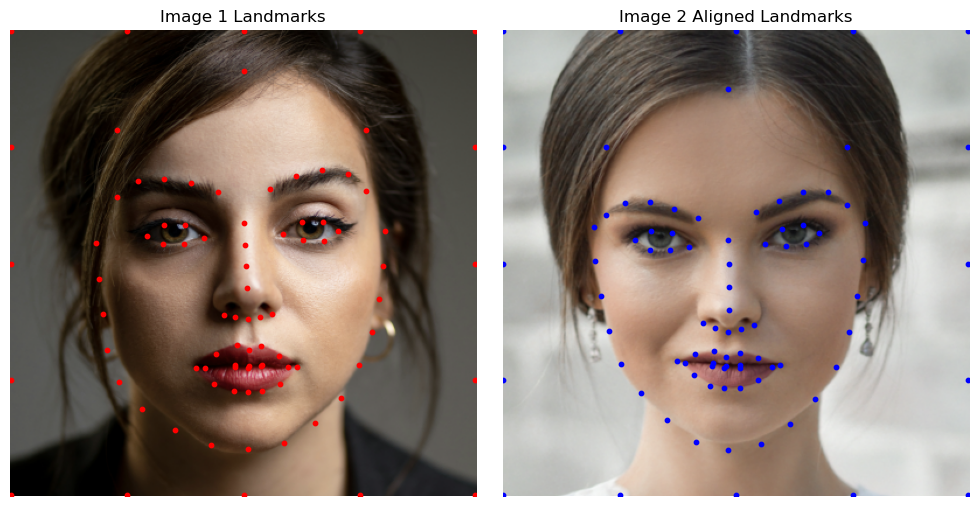

In [5]:
def visualize_landmarks(src_img, dst_img, src_landmarks, dst_landmarks):
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(src_img)
    plt.scatter(src_landmarks[:, 0], src_landmarks[:, 1], color='r', s=10)
    plt.title("Image 1 Landmarks")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(dst_img)
    plt.scatter(dst_landmarks[:, 0], dst_landmarks[:, 1], color='b', s=10)
    plt.title("Image 2 Aligned Landmarks")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_landmarks(img1_rgb, img2_rgb, landmarks1, landmarks2)

# 2. Trianglular mesh


In [6]:
def delaunay_triangulations(landmarks):
    # return the indices of the points that form the Delaunay triangulation
    return Delaunay(landmarks).simplices 

In [7]:
triangles1 = delaunay_triangulations(landmarks1)
triangles2 = delaunay_triangulations(landmarks2)

# Fixed the triangle mesh by setting w = 0.5 to ensure that the triangles are consistent across the images
landmarks = landmarks1 * (1-0.5) + landmarks2 * 0.5
triangles = delaunay_triangulations(landmarks)


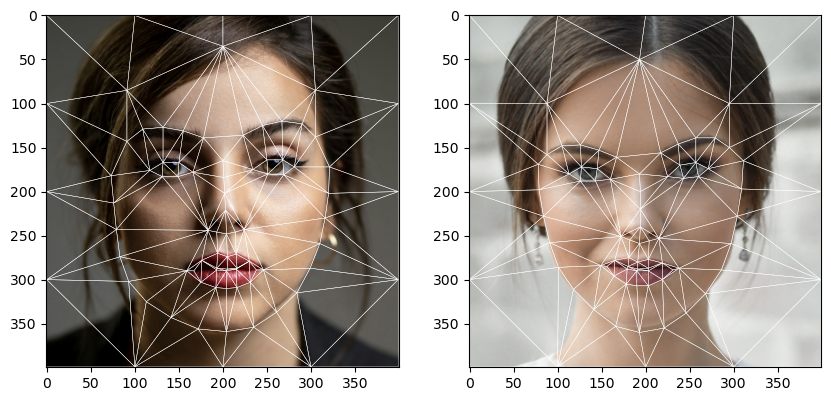

In [8]:
def visualize_triangles(src_img, dst_img, src_landmarks, dst_landmarks):
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(src_img)
    for tri in triangles:
        vertex = src_landmarks[tri] # [[144 438] [0 959] [0 0]]
        triangle = plt.Polygon(vertex, edgecolor='w', linewidth=0.3, fill=False)
        plt.gca().add_patch(triangle)
    
    plt.subplot(1, 2, 2)
    plt.imshow(dst_img)
    for tri in triangles:
        vertex = dst_landmarks[tri]
        triangle = plt.Polygon(vertex, edgecolor='w', linewidth=0.3, fill=False)
        plt.gca().add_patch(triangle)

visualize_triangles(img1_rgb, img2_rgb, landmarks1, landmarks2)

# 3. Apply affine warps


In [ ]:
import numpy as np

def get_affine_transform(src_tri, dst_tri):
    # Convert triangles to numpy arrays
    src_tri = np.array(src_tri, dtype=np.float32)
    dst_tri = np.array(dst_tri, dtype=np.float32)
    
    # Create the matrices to solve the linear equations
    A = []
    B = []
    
    for i in range(3):  # We have three pairs of points
        x, y = src_tri[i][0], src_tri[i][1]
        x_prime, y_prime = dst_tri[i][0], dst_tri[i][1]
        
        # Each point pair gives us two equations:
        # x' = a * x + b * y + c
        # y' = d * x + e * y + f
        A.append([x, y, 1, 0, 0, 0])  # Equation for x'
        A.append([0, 0, 0, x, y, 1])  # Equation for y'
        B.append(x_prime)
        B.append(y_prime)
    
    # Solve the linear system A * [a, b, c, d, e, f].T = B
    A = np.array(A, dtype=np.float32)
    B = np.array(B, dtype=np.float32)
    
    affine_params = np.linalg.solve(A, B) # AX = B
    
    # Reshape affine_params to form a 2x3 affine transformation matrix 
    affine_matrix = affine_params.reshape(2, 3)
    return affine_matrix

def warp_affine(img, affine_matrix, size):
    # Initialize an output image
    warped_img = np.zeros((size[1], size[0], img.shape[2]), dtype=img.dtype)
    
    # Invert the affine matrix to map destination to source
    affine_matrix_inv = np.linalg.inv(np.vstack([affine_matrix, [0, 0, 1]]))[:2, :]
    
    # Loop over every pixel in the output image (destination space)
    for x in range(size[0]):
        for y in range(size[1]):
            # Map the destination pixel back to the source coordinates
            src_point = np.dot(affine_matrix_inv, np.array([x, y, 1]))
            src_x, src_y = src_point[0], src_point[1]
            
            # Check if the calculated source coordinates are within bounds
            if 0 <= src_x < img.shape[1] and 0 <= src_y < img.shape[0]:
                # Bilinear interpolation to get the pixel color
                warped_img[y, x] = bilinear_interpolate(img, src_x, src_y)
            else:
               # Clamp out-of-bounds coordinates and use nearest neighbor
                src_x = int(np.clip(src_x, 0, img.shape[1] - 1))
                src_y = int(np.clip(src_y, 0, img.shape[0] - 1))
                warped_img[y, x] = img[src_y, src_x]
                    
    return warped_img

def bilinear_interpolate(img, x, y):
    # Perform bilinear interpolation for non-integer pixel positions.
    x0 = int(np.floor(x))
    y0 = int(np.floor(y))
    x1 = min(x0 + 1, img.shape[1] - 1)  # Ensure within width bounds
    y1 = min(y0 + 1, img.shape[0] - 1)  # Ensure within height bounds
    
    # Fractional parts
    a, b = x - x0, y - y0
    
    # perform bilinear interpolation
    top = (1 - a) * img[y0, x0] + a * img[y0, x1]
    bottom = (1 - a) * img[y1, x0] + a * img[y1, x1]
    interpolated_value = (1 - b) * top + b * bottom
    
    return interpolated_value

# 4. Blending with a mesh

In [18]:
def morph_triangle(src_img, dst_img, output, tri1, tri2, tri, w):
    # Morph triangles in two images and blend with the output.
    r1 = cv2.boundingRect(np.float32([tri1])) # (x, y, w, h) of the bounding rectangle of the triangle
    r2 = cv2.boundingRect(np.float32([tri2]))
    r = cv2.boundingRect(np.float32([tri]))
    
    # Offset triangle coordinates by left top corner of the respective rectangles
    tri1_offset = [(pt[0] - r1[0], pt[1] - r1[1]) for pt in tri1]
    tri2_offset = [(pt[0] - r2[0], pt[1] - r2[1]) for pt in tri2]
    tri_offset = [(pt[0] - r[0], pt[1] - r[1]) for pt in tri]
    
    # Crop the rectangles from each image that enclose the triangles
    img1_cropped = src_img[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    img2_cropped = dst_img[r2[1]:r2[1] + r2[3], r2[0]:r2[0] + r2[2]]
    
    affine_matrix1 = get_affine_transform(tri1_offset, tri_offset)
    affine_matrix2 = get_affine_transform(tri2_offset, tri_offset)

    # Apply affine warp to the triangles
    warped_img1 = warp_affine(img1_cropped, affine_matrix1, (r[2], r[3])) 
    warped_img2 = warp_affine(img2_cropped, affine_matrix2, (r[2], r[3]))
    
    # Blend the two warped triangles
    blended_triangle = ((1 - w) * warped_img1 + w * warped_img2).astype(np.uint8)

    # Create a mask with the triangle filled
    mask = np.zeros((r[3], r[2], 3), dtype=np.float32)
    cv2.fillConvexPoly(mask, np.int32(tri_offset), (1.0, 1.0, 1.0)) # Fill the triangle region with white

    # Copy triangular region of the blended triangle to the output image
    output[r[1]:r[1] + r[3], r[0]:r[0] + r[2]] = (
        output[r[1]:r[1] + r[3], r[0]:r[0] + r[2]] * (1.0 - mask) + blended_triangle * mask
    )
    return output


def morph_faces(src_img, dst_img, triangles, w):
    landmarks1 = np.array(get_landmarks(src_img))
    landmarks2 = np.array(get_landmarks(dst_img))
    landmarks = landmarks1 * (1 - w) + landmarks2 * w 
    
    output = np.zeros(src_img.shape, dtype=src_img.dtype)
    # Loop over all triangles which are consistent across the images
    for tri_indices in triangles:
        tri1 = [landmarks1[i] for i in tri_indices] # [ [x1, y1], [x2, y2], [x3, y3] ]
        tri2 = [landmarks2[i] for i in tri_indices]
        tri = [landmarks[i] for i in tri_indices]

        morph_triangle(src_img, dst_img, output, tri1, tri2, tri, w)
    
    return output


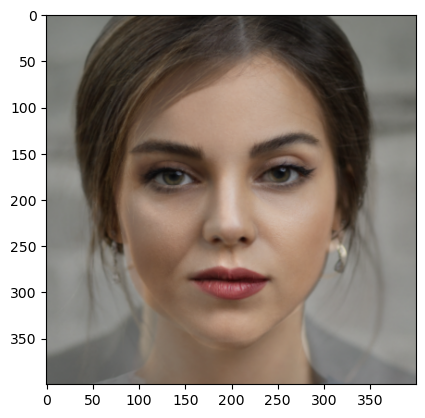

In [19]:
# test the morph_faces function with w = 0.5
morphed_img = morph_faces(img1_rgb, img2_rgb, triangles, 0.5)
plt.imshow(morphed_img)

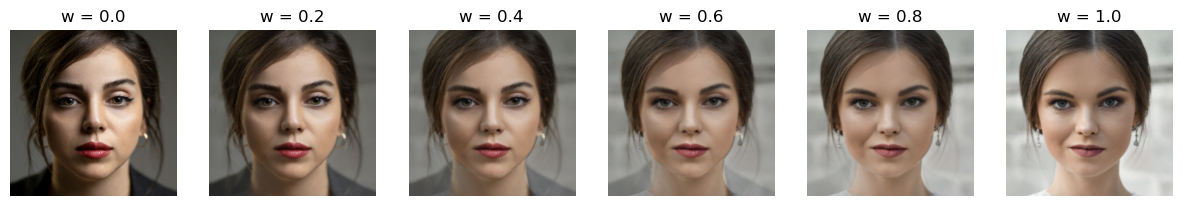

In [20]:
images = []
num_steps = 50
plt.figure(figsize=(15, 5))

selected_indices = [0, 10, 20, 30, 40, 50]
plot_idx = 1 

for i in range(0, num_steps + 1):
    w = i / num_steps
    
    morphed_img = morph_faces(img1_rgb, img2_rgb, triangles, w)
    images.append(morphed_img)
    
    # visualize the morphed images only for 0, 0.2, 0.4, 0.6, 0.8, 1
    if i in selected_indices:
        plt.subplot(1, 6, plot_idx)
        plt.imshow(morphed_img)
        plt.title(f"w = {round(w, 2)}")
        plt.axis('off')
        plot_idx += 1  # Move to the next subplot

plt.show()

# 4. Create Video

In [21]:
output_video = "output_video_part1.mp4"
fps = 10

# Create a video writer
writer = imageio.get_writer(output_video, fps=fps, codec='libx264', pixelformat='yuv420p')

# Write each frame to the video
for img in images:
    writer.append_data(img.astype(np.uint8))

writer.close()
print("The video has been successfully saved in QuickTime compatible format!")


The video has been successfully saved in QuickTime compatible format!


# Part2

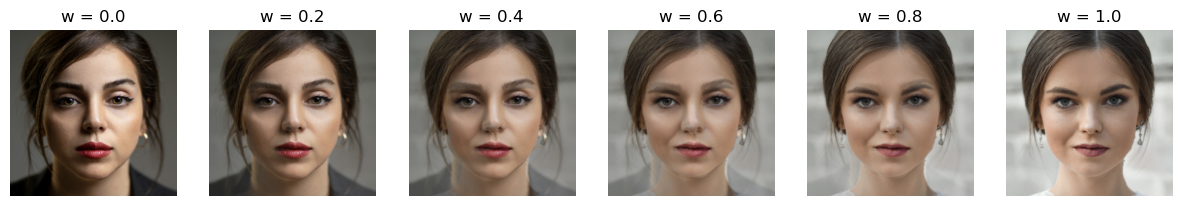

In [16]:
def compute_deformation_field(src_landmarks, dst_landmarks, alpha, output_shape):
    
    # Initialize variables
    height, width = output_shape
    xs = np.array(src_landmarks) # [[x1, y1], [x2, y2], ...]
    xe = np.array(dst_landmarks)
    
    # Create pixel coordinates grid
    x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))
    pixel_coords = np.stack([x_coords.ravel(), y_coords.ravel()], axis=1) 

    # Initialize weighted vector sums and weight sums 
    v_sum = np.zeros((height * width, 2), dtype=np.float32)
    weight_sum = np.zeros(height * width, dtype=np.float32)
    
    # Compute the deformation field
    for i in range(len(xs)):
        xs_i = xs[i]
        xe_i = xe[i]
        
        dist_sq = np.sum((pixel_coords - xs_i) ** 2, axis=1)
        weight = 1 / (dist_sq ** alpha + 1e-6) # Avoid division by zero

        # If alpha is small, the weight will be large for points close to the landmark
        # If alpha is large, the weight will be similar for all points
        deformation = (xe_i - xs_i) * weight[:, np.newaxis] # do np.newaxis to make it from (N,) to (N, 1)
        
        v_sum += deformation
        weight_sum += weight
    
    # Averaging all the deformations by the weights
    nonzero_weights = weight_sum > 0
    v_field = np.zeros_like(v_sum, dtype=np.float32)
    v_field[nonzero_weights] = v_sum[nonzero_weights] / weight_sum[nonzero_weights, np.newaxis]
    
    # Reshape the deformation field to the image shape
    return v_field.reshape(height, width, 2)

def meshless_morph(src_img, dst_img, src_landmarks, dst_landmarks, w, alpha):

    output_image = np.zeros(src_img.shape, dtype=src_img.dtype)
    
    v_field = compute_deformation_field(src_landmarks, dst_landmarks, alpha, src_img.shape[:2])
    
    for x in range (src_img.shape[1]):
        for y in range (src_img.shape[0]):
            x_new = int(x + v_field[y, x][0]) # convert to int to get the pixel coordinates
            y_new = int(y + v_field[y, x][1])
            
            if 0 <= x_new < src_img.shape[1] and 0 <= y_new < src_img.shape[0]:
                output_image[y, x] = (1-w) * src_img[y,x] + w * dst_img[y_new, x_new]
            else:
                # Clip out-of-bounds coordinates and use nearest neighbor
                x_new = int(np.clip(x_new, 0, src_img.shape[1] - 1))
                y_new = int(np.clip(y_new, 0, src_img.shape[0] - 1))
                output_image[y, x] = (1-w) * src_img[y,x] + w * dst_img[y_new, x_new]

    return output_image


# Perform meshless morphing between the two images
num_steps = 50
alpha = 0.4
meshless_morphed_images = []
for i in range(0, num_steps + 1):
    w = i / num_steps

    morphed_image = meshless_morph(img1_rgb, img2_rgb, landmarks1, landmarks2, w, alpha)
    meshless_morphed_images.append(morphed_image)
    
# Visualize the morphed images
plt.figure(figsize=(15, 5))

selected_indices = [0, 10, 20, 30, 40, 50]
plot_idx = 1

for i in range(0, num_steps + 1):
    if i in selected_indices:
        plt.subplot(1, 6, plot_idx)
        plt.imshow(meshless_morphed_images[i])
        plt.title(f"w = {round(i/50, 2)}")
        plt.axis('off')
        plot_idx += 1


In [17]:

output_video = "output_video_part2.mp4"
fps = 10

# Create a video writer
writer = imageio.get_writer(output_video, fps=fps, codec='libx264', pixelformat='yuv420p')

# Write each frame to the video
for img in meshless_morphed_images:
    writer.append_data(img.astype(np.uint8))

writer.close()
print("The video has been successfully saved in QuickTime compatible format!")


The video has been successfully saved in QuickTime compatible format!
